In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
from tqdm import tqdm

from datetime import datetime


In [3]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [4]:
df = get_energy_data()

  0%|          | 0/254 [00:00<?, ?it/s]/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_45736/2942256061.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 254/254 [01:26<00:00,  2.92it/s]


In [7]:
df.head()

,Netzlast_Gesamt
date_time,
2018-12-24 00:00:00,42029.25
2018-12-24 01:00:00,39610.25
2018-12-24 02:00:00,39138.75
2018-12-24 03:00:00,39421.00
2018-12-24 04:00:00,40747.75


Rename column for convenience

In [8]:
df = df.rename(columns={"Netzlast_Gesamt": "gesamt"})

Rescale Netzlast so it fits requirements

In [9]:
df['gesamt'] = df['gesamt'] / 1000

Check dtypes and if columns contain and missing values

In [10]:
df.dtypes

gesamt    float64
dtype: object

In [11]:
df.isna().any()

gesamt    False
dtype: bool

Define weekday column

In [12]:
df["weekday"] = df.index.weekday #Monday=0, Sunday=6
#df["time"] = df.index.strftime("%H:%M")

Lead times are

In [13]:
horizons_def = [36, 40, 44, 60, 64, 68]#[24 + 12*i for i in range(5)]
horizons_def

[36, 40, 44, 60, 64, 68]

Adapt horzions so they actually fit

In [14]:
horizons = [h+1 for h in horizons_def]
horizons

[37, 41, 45, 61, 65, 69]

In [15]:
def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [16]:
LAST_IDX = -1
LAST_DATE = df.iloc[LAST_IDX].name

Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [17]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
horizon_date

[Timestamp('2023-11-04 23:00:00'),
 Timestamp('2023-11-05 03:00:00'),
 Timestamp('2023-11-05 07:00:00'),
 Timestamp('2023-11-05 23:00:00'),
 Timestamp('2023-11-06 03:00:00'),
 Timestamp('2023-11-06 07:00:00')]

quantile levels

In [18]:
tau = [.025, .25, .5, .75, .975]

In [19]:
#rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

In [20]:
last_t = 100

for i,d in enumerate(horizon_date):
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = df.iloc[:LAST_IDX]
    
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    pred_baseline[i,:] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)

In [21]:
pred_baseline

array([[38.45935625, 40.7279375 , 43.005     , 46.9073125 , 53.4296    ],
       [33.38661875, 35.1395625 , 37.333     , 41.6080625 , 47.3592375 ],
       [36.16175   , 37.5958125 , 39.7045    , 43.6374375 , 49.49936875],
       [39.18475   , 41.7856875 , 43.785375  , 47.9014375 , 54.1133    ],
       [34.92703125, 37.8288125 , 40.168     , 44.34525   , 50.94234375],
       [38.148725  , 54.4201875 , 58.385625  , 62.7883125 , 69.96705   ]])

Visually check if quantiles make sense

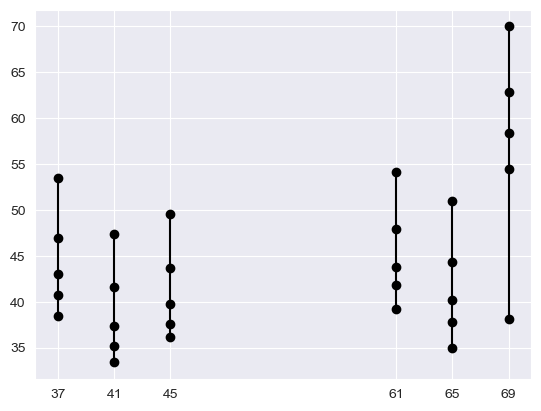

In [22]:
x = horizons
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [23]:
from datetime import datetime, date, timedelta
date_str = datetime.today().strftime('%Y%m%d')

In [24]:
date_str = date.today() #- timedelta(days=1)
date_str = date_str.strftime('%Y%m%d')
date_str

'20231103'

In [25]:
df_sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,20231103,energy,36 hour,38.459356,40.727937,43.005000,46.907312,53.429600
1,20231103,energy,40 hour,33.386619,35.139562,37.333000,41.608063,47.359237
2,20231103,energy,44 hour,36.161750,37.595812,39.704500,43.637438,49.499369
3,20231103,energy,60 hour,39.184750,41.785688,43.785375,47.901438,54.113300
4,20231103,energy,64 hour,34.927031,37.828812,40.168000,44.345250,50.942344
5,20231103,energy,68 hour,38.148725,54.420187,58.385625,62.788313,69.967050


In [26]:
#need to change this
PATH = "/save/to/path"


df_sub.to_csv(PATH+date_str+"_power_benchmark.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/save/to'